# Figure 1: Data overview

Focus on PGx information available in general and compare it to the available information in Africa. For all drugs and then also a focus on our drugs of interest and ADME genes.

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import stylia as st
from stylia import NamedColors, ContinuousColorMap, ONE_COLUMN_WIDTH, TWO_COLUMNS_WIDTH

DATAPATH = "../data"
RESULTSPATH = "../results"

colors = NamedColors()
red = colors.get("red")
blue = colors.get("blue")
purple = colors.get("purple")
yellow = colors.get("yellow")
green = colors.get("green")
gray = colors.get("gray")

## Figure 1A
Drug annotations for infectious vs non-infectious diseases in PharmGKB

Problem: diseases in PharmGKB are not grouped in Infectious vs Non Infectious, we have a list of ~3500 conditions. Add a column to diseases.csv using ChatGPT and revise manually
We can do only malaria and TB vs the rest, but it would be quite misrrepresentative.

Also, many drugs do not have the disease correctly associated (it was missing in the clinical_annotations.csv file originally, so the fields have been left empty). Even if we annotate them manually, how do we know if one annotation is for a specific disease or for another? many drugs are associated to more than one disease.

In [2]:
df = pd.read_csv(os.path.join(DATAPATH,"pharmgkb_processed", "13_pgkb_merged.csv"), low_memory=False)
d2d = pd.read_csv(os.path.join(DATAPATH, "drugbank", "drugbank_atc_codes.csv"))
len(set(df["cid"])-set(d2d["pharmgkb_id"]))

df_ = df.merge(d2d, how='left', left_on='cid', right_on='pharmgkb_id')
df_.drop(columns=["pharmgkb_id"], inplace=True)
df2d = df_[["cid", "chemical", "atc_codes", "disease", "is_infectious", "is_noncommunicable"]]
df2d.drop_duplicates(keep="first", inplace=True)
df2d.sort_values(by="cid", inplace=True)
df2d.to_csv(os.path.join("data", "drugs2disease.csv"), index=False)
print(len(set(df["cid"])), len(set(df_["cid"])), len(set(df2d["cid"])))

1116 1116 1116


/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_77476/3123038068.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2d.drop_duplicates(keep="first", inplace=True)
/var/folders/rx/fqf_ssrj14q0h5dmx8vgdvpm0000gn/T/ipykernel_77476/3123038068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2d.sort_values(by="cid", inplace=True)


In [3]:
d2d = pd.read_csv("data/drugs2disease_manual.csv")
print(len(set(d2d["cid"])))
d2d = d2d[['cid', 'chemical', 'atc_codes', 'is_infectious','is_noncommunicable']]
d2d = d2d.drop_duplicates(keep="first")
print(d2d.shape)
df_ = df.merge(d2d, how='left', on=['cid', 'chemical'])
print(df.shape, df_.shape)

1116
(1116, 5)
(88784, 12) (88784, 15)


Text(0.5, 1.0, 'PharmGKB annotations by disease class')

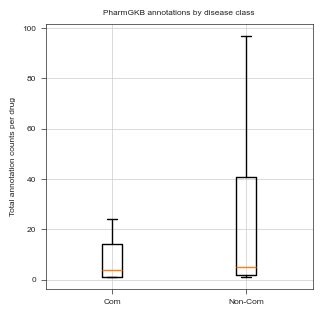

In [21]:
ncom = df_[df_["is_noncommunicable"]==1]
com = df_[df_["is_infectious"]==1]

ncom_counts = ncom['cid'].value_counts().reset_index()
com_counts = com['cid'].value_counts().reset_index()

fig, axs = st.create_figure(1,1)
ax = axs.next()
plt.boxplot([com_counts['count'], ncom_counts['count']], labels=['Com', 'Non-Com'], showfliers=False)
ax.set_ylabel("Total annotation counts per drug")
ax.set_xlabel("")
ax.set_title("PharmGKB annotations by disease class")

In [77]:
# our drugs of interest
drugs = pd.read_csv(os.path.join(DATAPATH, "of_interest", "curated_drugs_for_gradient.tsv"), sep="\t")
df = pd.read_csv(os.path.join(DATAPATH,"pharmgkb_processed", "13_pgkb_merged.csv"), low_memory=False)
set([x.lower() for x in drugs["Drug"]])-set(df["chemical"]) 

{'bedaquiline',
 'capreomycin',
 'clofazimine',
 'cycloserine',
 'delamanid',
 'dihydroartemisinin',
 'doxycycline',
 'linezolide',
 'p-aminosalicylic acid',
 'piperaquine',
 'pretomanid',
 'rifampicin',
 'rifapentine',
 'strepomycin',
 'terizidone'}

Text(0.5, 1.0, 'PharmGKB annotations by disease class')

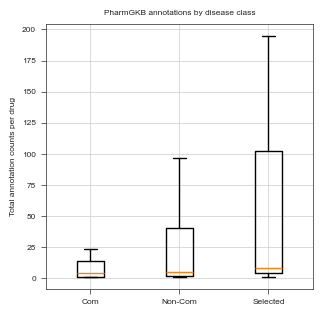

In [79]:
drugs_ann = df[df["chemical"].isin([x.lower() for x in drugs["Drug"]])]
drugs_counts = drugs_ann["cid"].value_counts().reset_index()

fig, axs = st.create_figure(1,1)
ax = axs.next()
plt.boxplot([com_counts['count'], ncom_counts['count'], drugs_counts["count"]], labels=['Com', 'Non-Com', 'Selected'], showfliers=False)
ax.set_ylabel("Total annotation counts per drug")
ax.set_xlabel("")
ax.set_title("PharmGKB annotations by disease class")

## Figure 1B
All genes vs ADME genes.
In pharmgkb or in the 1000Genomes curation?

Why are adme genes not in 1000Genomes

283
127


{'whiskers': [<matplotlib.lines.Line2D at 0x3273ecfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x3273ec610>,
 'boxes': [<matplotlib.lines.Line2D at 0x32748c850>,
 'medians': [<matplotlib.lines.Line2D at 0x3273ffb10>,
 'fliers': [],
 'means': []}

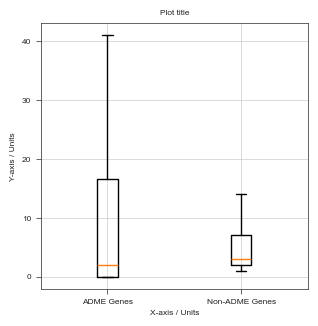

In [17]:
# In PHARMGKB
df = pd.read_csv(os.path.join(DATAPATH, "pharmgkb_processed", "13_pgkb_merged.csv"), low_memory=False)
admegenes = pd.read_csv(os.path.join(DATAPATH, "of_interest", "adme_gene_list.tsv"), sep="\t")
genes = admegenes["Gene Symbol"].tolist()
print(len(set(genes))) #CYP20A1 is repeated!

genesmissing = list(set(genes)-set(df["gene"]))
print(len(set(genesmissing)))

admevars = df[df["gene"].isin(genes)]
nonadmevars = df[~df["gene"].isin(genes)]

admevars_counts = admevars['gene'].value_counts().reset_index()
admevars_counts.columns = ['gene', 'frequency']
nonadmevars_counts = nonadmevars['gene'].value_counts().reset_index()
nonadmevars_counts.columns = ['gene', 'frequency']

missing_admevars_df = pd.DataFrame({'gene': list(genesmissing), 'frequency': 0})
admevars_counts = pd.concat([admevars_counts, missing_admevars_df], ignore_index=True)

fig, axs = st.create_figure(1,1)
ax = axs.next()
plt.boxplot([admevars_counts['frequency'], nonadmevars_counts['frequency']], labels=['ADME Genes', 'Non-ADME Genes'], showfliers=False)

13


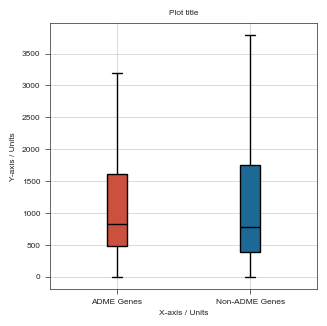

In [45]:
# in 1000 Genomes
df = pd.read_csv(os.path.join(DATAPATH, "variants", "1000_Genomes", "subset_snvs_protein_coding_1kGPhg38_gene_level.tsv"), sep="\t")
genesmissing = list(set(genes)-set(df["gene"]))
print(len(set(genesmissing)))

admevars = df[df["gene"].isin(genes)]
nonadmevars = df[~df["gene"].isin(genes)]

admevars_counts = admevars[['gene', 'total_variants']]
nonadmevars_counts = nonadmevars[['gene', 'total_variants']]

missing_admevars_df = pd.DataFrame({'gene': list(genesmissing), 'total_variants': 0})
admevars_counts = pd.concat([admevars_counts, missing_admevars_df], ignore_index=True)

fig, axs = st.create_figure(1,1)
ax = axs.next()
colors = [red,blue]
medianprops = dict(color="black")
bp = ax.boxplot([admevars_counts['total_variants'], nonadmevars_counts['total_variants']], patch_artist=True, labels=['ADME Genes', 'Non-ADME Genes'], medianprops= medianprops,showfliers=False)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

(array([21., 41., 42., 40., 24., 20., 15., 15., 10.,  8.,  2.,  7.,  2.,
         6.,  5.,  1.,  3.,  2.,  1.,  2.,  1.,  4.,  2.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([    0.  ,   213.41,   426.82,   640.23,   853.64,  1067.05,
         1280.46,  1493.87,  1707.28,  1920.69,  2134.1 ,  2347.51,
         2560.92,  2774.33,  2987.74,  3201.15,  3414.56,  3627.97,
         3841.38,  4054.79,  4268.2 ,  4481.61,  4695.02,  4908.43,
         5121.84,  5335.25,  5548.66,  5762.07,  5975.48,  6188.89,
         6402.3 ,  6615.71,  6829.12,  7042.53,  7255.94,  7469.35,
         7682.76,  7896.17

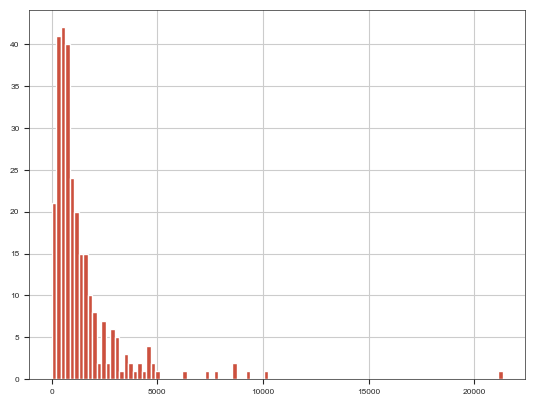

In [43]:
plt.hist(admevars_counts["total_variants"], bins=100, color=red)
#plt.hist(nonadmevars_counts["total_variants"], bins=100, color=blue, alpha=0.5)

## Figure 1C

Origin of variants in ADME Genes. Plot a stacked barplot

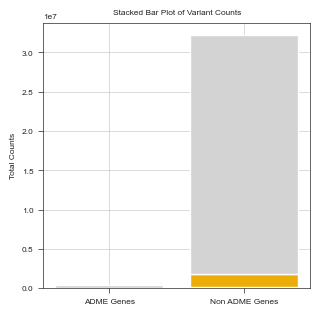

In [70]:
# Summing the columns
afr_ab_adme = admevars["afr_abundant_variants"].sum()
afr_sp_adme = admevars["afr_specific_variants"].sum()
total_adme = admevars["total_variants"].sum()
rest_adme = total_adme - afr_ab_adme - afr_sp_adme

afr_ab = nonadmevars["afr_abundant_variants"].sum()
afr_sp = nonadmevars["afr_specific_variants"].sum()
total = nonadmevars["total_variants"].sum()
rest = total - afr_ab - afr_sp

y1=[afr_sp_adme, afr_sp]
y2=[afr_ab_adme, afr_ab]
y3=[rest_adme, rest]

fig, axs = st.create_figure(1,1)
ax=axs.next()
ax.bar(["ADME Genes", "Non ADME Genes"], y1, color=purple)
ax.bar(["ADME Genes", "Non ADME Genes"], y2, bottom=y1, color=yellow)
ax.bar(["ADME Genes", "Non ADME Genes"], y3,bottom=[x+y for x,y in zip(y1,y2)], color=gray)
ax.set_xlabel('')
ax.set_ylabel('Total Counts')
ax.set_title('Stacked Bar Plot of Variant Counts')

plt.show()

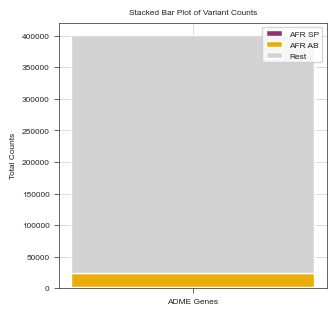

In [71]:
# Summing the columns
afr_ab_adme = admevars["afr_abundant_variants"].sum()
afr_sp_adme = admevars["afr_specific_variants"].sum()
total_adme = admevars["total_variants"].sum()
rest_adme = total_adme - afr_ab_adme - afr_sp_adme

y1=[afr_sp_adme]
y2=[afr_ab_adme]
y3=[rest_adme]

# Plotting
fig, axs = st.create_figure(1,1)
ax=axs.next()
ax.bar(["ADME Genes"], y1, color=purple)
ax.bar(["ADME Genes"], y2, bottom = y1, color=yellow)
ax.bar(["ADME Genes"], y3, bottom = [x+y for x,y in zip(y1,y2)], color=gray)
ax.set_xlabel('')
ax.set_ylabel('Total Counts')
ax.set_title('Stacked Bar Plot of Variant Counts')
ax.legend(["AFR SP", "AFR AB", "Rest"])

plt.show()

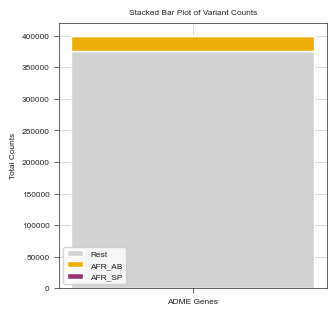

In [74]:
# Summing the columns
afr_ab_adme = admevars["afr_abundant_variants"].sum()
afr_sp_adme = admevars["afr_specific_variants"].sum()
total_adme = admevars["total_variants"].sum()
rest_adme = total_adme - afr_ab_adme - afr_sp_adme

y1=[afr_sp_adme]
y2=[afr_ab_adme]
y3=[rest_adme]

# Plotting
fig, axs = st.create_figure(1,1)
ax=axs.next()
ax.bar(["ADME Genes"], y3, color=gray)
ax.bar(["ADME Genes"], y2, bottom = y3, color=yellow)
ax.bar(["ADME Genes"], y1, bottom = [x+y for x,y in zip(y3,y2)], color=purple)
ax.set_xlabel('')
ax.set_ylabel('Total Counts')
ax.set_title('Stacked Bar Plot of Variant Counts')
ax.legend(["Rest", "AFR_AB", "AFR_SP"])

plt.show()